In [ ]:
# !pip install tensorflow
# !pip install --upgrade keras
# !pip install tensorflow-datasets
# !pip install tensorflow[and-cuda]
# !pip install keras-tuner scikit-learn
# !pip install matplotlib
# !pip install tensorflow
# !pip install keras-tuner

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow_datasets as tfds
from kerastuner import RandomSearch

In [3]:
base_mode = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),)

for layer in base_mode.layers:
    layer.trainable = False

I0000 00:00:1769955739.354483  169222 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2798 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
2026-02-01 16:22:21.151789: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 411041792 exceeds 10% of free system memory.


In [4]:
model = Sequential([
    base_mode,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax'),
])

In [5]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

In [7]:
n_classes = info.features['label'].num_classes

2026-02-01 16:22:21.830835: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-02-01 16:22:21.904602: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2026-02-01 16:22:21.911103: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


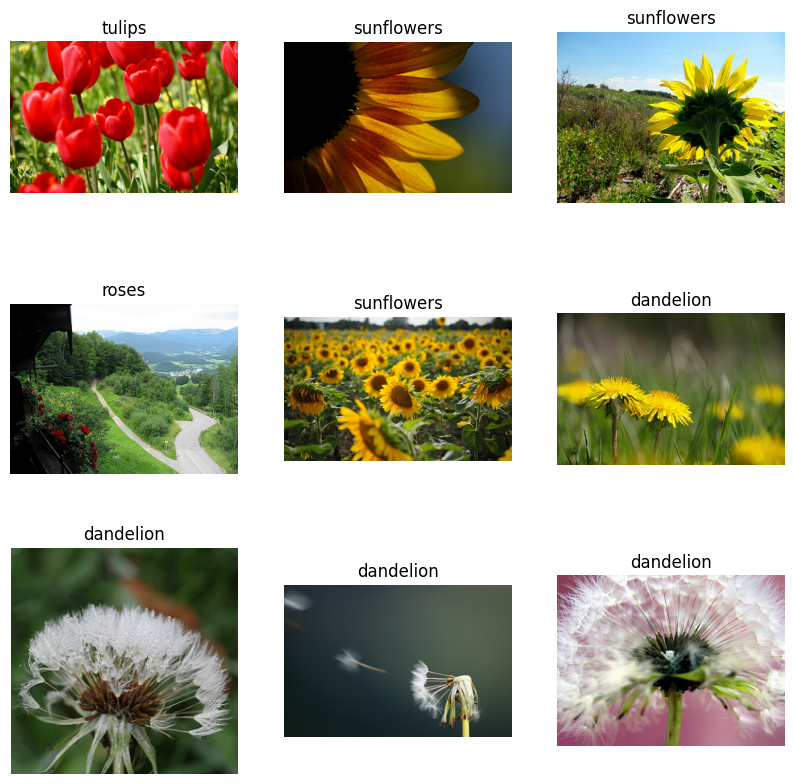

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(dataset['train'].take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(info.features['label'].int2str(label))
    plt.axis("off")
plt.show()

In [9]:
IMAGE_SIZE = 224

In [10]:
images, labels = [], []

for image, label in tfds.as_numpy(dataset['train']):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    images.append(image)
    labels.append(label)

2026-02-01 16:22:28.365218: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


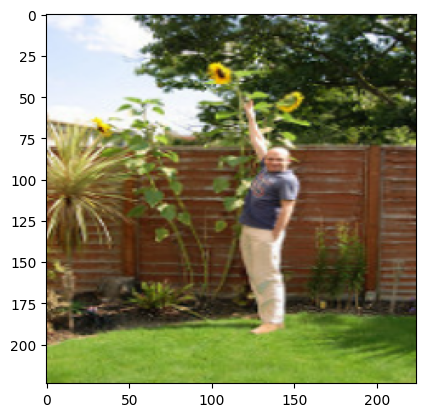

In [11]:
plt.imshow(images[10].numpy().astype("uint8"))

In [12]:
images = np.array(images)
labels = np.array(labels)

In [13]:
type(images), type(labels)

(numpy.ndarray, numpy.ndarray)

In [14]:
images.shape

(3670, 224, 224, 3)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [17]:
train_datagen = train_datagen.flow(X_train, tf.keras.utils.to_categorical(y_train, n_classes))
test_datagen = test_datagen.flow(X_test, tf.keras.utils.to_categorical(y_test, n_classes))

In [18]:
model.fit(train_datagen, validation_data=test_datagen, epochs=3)

Epoch 1/3


2026-02-01 16:22:44.257727: I external/local_xla/xla/service/service.cc:163] XLA service 0x78fa04005b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-01 16:22:44.257740: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2026-02-01 16:22:45.633222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-01 16:22:47.893583: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-01 16:22:51.873973: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

 9/92 ━━━━━━━━━━━━━━━━━━━━ 29s 361ms/step - accuracy: 0.2203 - loss: 1.6070

2026-02-01 16:23:28.567584: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-01 16:23:28.814007: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.2967 - loss: 1.5967

2026-02-01 16:24:23.458576: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[30,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-01 16:24:23.785543: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[30,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

92/92 ━━━━━━━━━━━━━━━━━━━━ 123s 880ms/step - accuracy: 0.3351 - loss: 1.5824 - val_accuracy: 0.3420 - val_loss: 1.5544
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.3617 - loss: 1.5087 - val_accuracy: 0.3392 - val_loss: 1.4716
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 383ms/step - accuracy: 0.3862 - loss: 1.4291 - val_accuracy: 0.3678 - val_loss: 1.4100


In [23]:
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', values=[0.001, 0.01, 0.1])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [25]:
turner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld'
)

/home/maxmaster/data/ITI/ai/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# turner.search() 